In [352]:
import random
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize_scalar
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm

## I - Comparison of the existing estimators

In [406]:
#Simulation of the data
random.seed(2040)
n= 100
T= 5
phizero =  0.4

results_AH81 = list()
results_AB95 = list()
results_HP = list()
HP_direct = list()
HK_direct = list()

for l in range(500):
    #definition of y0 for the n individuals 
    a = np.random.normal(0,1, size = n)
    y0 = np.vectorize(lambda x: np.random.normal(x/(1-phizero),1/(1-phizero**2)**0.5))(a)
    epsilon = np.random.normal(0, 1, size = n*T)


    #matrix where each row is the time period, and each column is the ith individual
    y=np.zeros((T+1,n))

    #the first row of the matrix is y0
    y[0] = y0

    #We implement the first line as zeros for simplicity of index
    delta_y = np.zeros((T+1,n))

    #recursive definition of y, delta_y and delta_epsilon
    for j in range(1,T+1):
        y[j] = a + y[j-1]*phizero + epsilon[j]
        delta_y[j] = y[j] - y[j-1]
        
    
    #Different criteria we want to minimize
    results_AH81.append(minimize_scalar(moments, bounds = (-0.99,0.99), method = "bounded").x)
    results_AB95.append(minimize_scalar(moments_AB95, bounds = (-0.99,0.99), method = "bounded").x)
    results_HP.append(minimize_scalar(moments_HP, bounds = (-0.99,0.99), method = "bounded").x)
    HP_direct.append(HP_estim_direct(y,n,T))
    HK_direct.append(HK_estim_direct(y,n,T))

In [392]:
def plot_results(results, title):
    plt.hist(results, 100)
    plt.axvline(x = phizero, color='r', linestyle=':', label = "target value")
    plt.axvline(x = np.mean(results), color = "b", label = "mean")
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

We have to rewrite the condition (5), so we can see the parameter $\phi$ 

$$\sum_{i = 1}^{n} \Delta y_{i,t-1} \times y_{i, t-s} =  \sum_{i = 1}^{n}( \phi \Delta y_{i,t-2} + \Delta \varepsilon_{i,t-1})\times y_{i, t-s}) $$

Yet, $$\Delta \varepsilon_{i,t-1} = \varepsilon_{i,t -1} - \varepsilon_{i,t-2} = y_{i,t-1}  - \phi y_{i, t-2} - y_{i, t-2} + \phi y_{i, t-3} = y_{i,t-1}  - (1 + \phi) ( y_{i, t-2}) + \phi y_{i, t-3}$$

Thus the moment condition is finally: 
$$\sum_{i = 1}^{n} \Delta y_{i,t-1} \times y_{i, t-s}) =  \sum_{i = 1}^{n}( y_{i,t-1} - y_{i, t-2} +  \phi y_{i, t-3})\times y_{i, t-s}) = \sum_{i = 1}^{n}( \Delta y_{i,t-1} +  \phi y_{i, t-3})\times y_{i, t-s})$$

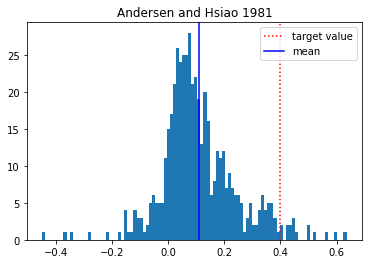

In [399]:
def moments(phi): 
    moments = []
    for t in range(3, T+1):
        for s in range(2, t):
            moments.append(sum([y[t-s][i]*(delta_y[t-1][i] + phi*y[t-3][i]) for i in range(n)])/n)
    return(np.dot(moments, moments)) 

plot_results(results_AH81, "Andersen and Hsiao 1981")

Condition from Arellano Bover 1995: 
$$ E(u_{i,t},\Delta y_{i,t-1})=E((y_{i,t}-\phi_0 y_{it-1})(y_{i,t-1}-y_{it-2})=0, \text{for } t=2,3,...,T $$


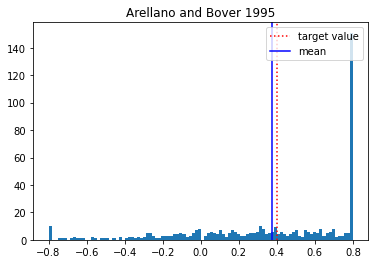

In [400]:
def moments_AB95(phi): 
    moments = []
    for t in range(2, T+1):
        moments.append(sum([(y[t][i] - phi*y[t-1][i])*(y[t-1][i] - y[t-2][i]) for i in range(n)])/n)
    return(np.dot(moments, moments))
plot_results(results_AB95, "Arellano and Bover 1995")

In [401]:
def moments_HP(phi):
    moments = []
    for t in range(2, T):
        moments.append(sum([delta_y[t-1][i]*(2*delta_y[t][i] + delta_y[t-1][i]) - phi*delta_y[t-1][i] for i in range(n)])/n)
    return(np.dot(moments, moments)) 

In [387]:
#Formula 7 p70 in the paper
def HP_estim_direct(y,n,T):
    numerateur=0
    denominateur=0
    for i in range(n) :
        for t in range(1,T+1):
            numerateur+=delta_y[t-1][i]*(2*delta_y[t][i] + delta_y[t-1][i])
            denominateur+=(delta_y[t-1][i])**2

    estim=numerateur/denominateur
    return estim


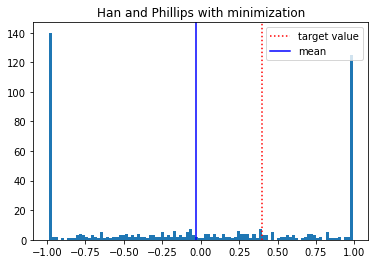

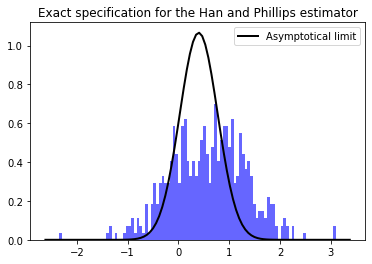

In [458]:
plot_results(results_HP, "Han and Phillips with minimization")

plt.hist(HP_direct, density = True, bins= 100, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu = phizero
std = (2*(1 + phizero)/n*T)**0.5
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2, label = "Asymptotical limit")
plt.legend()
plt.title("Exact specification for the Han and Phillips estimator")
plt.show()

Han and Phillips (forthcoming) proves the fact that the exact simulator is gaussian, for N and T large.  

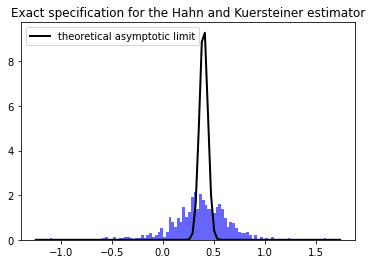

In [457]:
#Fonction codée par Gaetan
def HK_estim_direct(y,n,T):
    
    within_ = [1/T*sum([y[t-1][i] for t in range(1,T)]) for i in range(n)]
    within = [1/T*sum([y[t][i] for t in range(1,T)]) for i in range(n)]

    Upsilon=0
    for i in range(n):
        for t in range(1,T):
            Upsilon+=(y[t-1][i]-within_[i])**2

    Upsilon*=1/(n*T)

    HK_num_1=0
    for i in range(n):
        for t in range(1,T):
            HK_num_1+=(y[t-1][i]-within_[i])*(y[t][i]-within_[i])
            
    HK_num_1*=1/(n*T)

    phi_OLS=HK_num_1/Upsilon

    omega=(1-phi_OLS**2)*Upsilon

    HK_num_2 = (1/T)*(1-phi_OLS)*omega

    HK_estim=(HK_num_1+HK_num_2)/Upsilon

    return(HK_estim)


plt.hist(HK_direct, bins= 100, alpha=0.6, density = True, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu = phizero
std = (1 - phizero**2)**0.5/(n*T)**0.5
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2, label = "theoretical asymptotic limit")
plt.legend()
plt.title("Exact specification for the Hahn and Kuersteiner estimator")
plt.show()

# II- Indirect inference

Mnt il faut coder l'inférence indirecte :

1) On crée une fonction qui génère des données avec un phi donné

2) On crée une fonction qui calcul OLS avec des données donnée

3) On utilise la super fonction trop cool qui minimise des fonctions

In [467]:
#Data generation 
def true_model_generation(phi,n,T):
    phizero=float(phi)
    a = np.random.normal(0,1, size = n)
    y0 = np.vectorize(lambda x: np.random.normal(x/(1-phizero),1/(1-phizero**2)**0.5))(a)
    epsilon = np.random.normal(0, 1, size = n*T)
    y=np.zeros((T,n))
    y[0]=y0
    
    #the first row of the matrix is y0
    y[0] = y0

    #We implement the first line as zeros for simplicity of index
    delta_y = np.zeros((T+1,n))

    #recursive definition of y, delta_y and delta_epsilon
    for j in range(1,T+1):
        y[j] = a + y[j-1]*phizero + epsilon[j]
        delta_y[j] = y[j] - y[j-1]
        
    return(y)

In [ ]:
H = 10 


In [224]:
#Formule du papier pour l'estimateur
def ML_papier(y):
    mat_y_=y[:,:T-1]
    mat_y=y[:,1:]
    
    y=mat_y.reshape(n*(T-1),1)
    y_=mat_y_.reshape(n*(T-1),1)
        
    phi_ML_aux=np.linalg.inv((y_.T)@y_)@((y_.T)@y)
    
    return phi_ML_aux

#Calcul de la binding function simulée pour un phi donnée
def b_NT(phi,H):
    b_simul=[ML_papier(gener_donne(phi,n,T)) for H in range(H)]
    return np.mean(b_simul)

In [225]:
#Minimisation de l'écart entre la binding fuction simulée et la "vraie valeur"
# de la binding function

def estim_indirect(H):
    x=ML_papier(y)
    def ecartL2(phi):
        return abs(x-b_NT(phi,H))
    return minimize_scalar(ecartL2,method="bounded", bounds=(0.01,0.99) )


estim_indirect(40)

     fun: array([[0.00032135]])
 message: 'Solution found.'
    nfev: 18
  status: 0
 success: True
       x: array([[0.41676448]])